# Exploratory analysis of the flights dataset

In [92]:
# Imports
import gcp.bigquery as bq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Mapping from airline 2 letter code to airline name
# source: https://en.wikipedia.org/wiki/List_of_airline_codes
airline_code_to_name = {
  'AA': 'American Airlines',
  'AS': 'Alaska Airlines, Inc',
  'B6': 'JetBlue Airways',
  'CO': 'Continental Airlines',
  'DL' : 'Delta Air Lines',
  'EV': 'Atlantic Southeast Airlines',
  'F9': 'Frontier Airlines',
  'FL': 'AirTran Airways',
  'HA': 'Hawaiian Airlines',
  'MQ': 'American Eagle Airlines',
  'OO': 'SkyWest Airlines',
  'UA': 'United Airlines',
  'US': 'US Airways',
  'VX': 'Virgin America',
  'WN': 'Southwest Airlines',
  'XE': 'Unknown',
  'YV': 'Mesa Airlines',
}

In [2]:
# Print table schema to make work easier
%bigquery schema --table flighs_dataset.datatonic_extended


A few sanity checks on the dataset to make sure that it corresponds to what was described in the instructions

In [23]:
%%sql --module sanity_checks
SELECT
  COUNT(0) as num_rows,
  MIN(date) as earliest_date,
  MAX(date) as latest_date
FROM flighs_dataset.datatonic;

In [47]:
bq.Query(sanity_checks).results()

QueryResultsTable job_-msCa5oJwcCLZJhHfFWTcvcT4ng

## Analysis of flights

In [154]:
# A modular definition of a SQL query that returns the distribution of flights according to
# certain slice (e.g. departure_state, day_of_week, ...)
def query_distribution_for_slices(slices):
  return """SELECT
              {0},
              COUNT(0) as frequency,
              FROM flighs_dataset.datatonic_extended
              GROUP BY {0}
              ORDER BY frequency DESC;""".format(",".join(slices))

def get_flights_distribution_for_slices(slices):
  return bq.Query(query_distribution_for_slices(slices)).to_dataframe()

"""
Plots the distribution of flights for the given slice

Args:
  distr_df: pandas.Dataframe as returned by get_flights_distribution_for_slices(slice)
  slice: list of length one with the name of the slice
"""
def plot_distribution_for_slice(distr_df, slice):
  distr_df['frequency'] /= distr_df.frequency.sum()
  distr_df['frequency'] *= 100
  fig = plt.figure(figsize = (30,14))
  plot = fig.add_subplot(111)
  ticks = np.arange(0.5, len(distr_df[slice]) + 0.5)
  plot.stem(ticks, distr_df['frequency'], linefmt='b-', markerfmt='bo', lw=5)
  plt.xticks(ticks, distr_df[slice])
  plt.title("Distribution of flights by {}".format(slice))
  plt.xlabel(slice)
  plt.ylabel("percent of flights")
  plt.show()

### Distribution of flights by departure state.

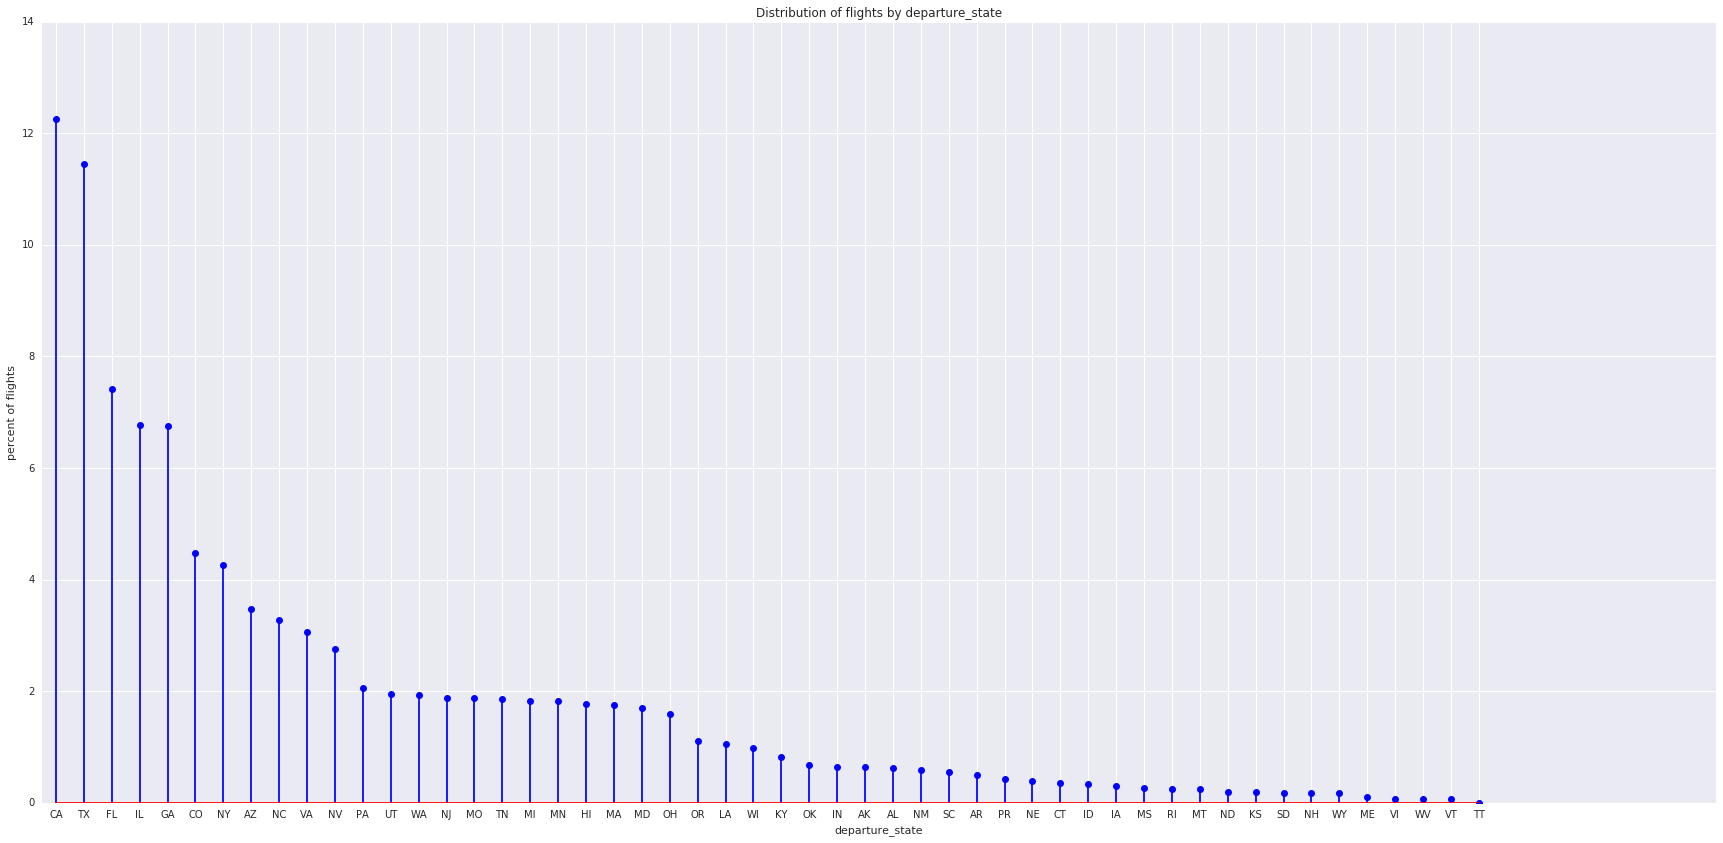

In [155]:
distr_departure_state = get_flights_distribution_for_slices(["departure_state"])
plot_distribution_for_slice(distr_departure_state, "departure_state")

### Distribution of flights by arrival state

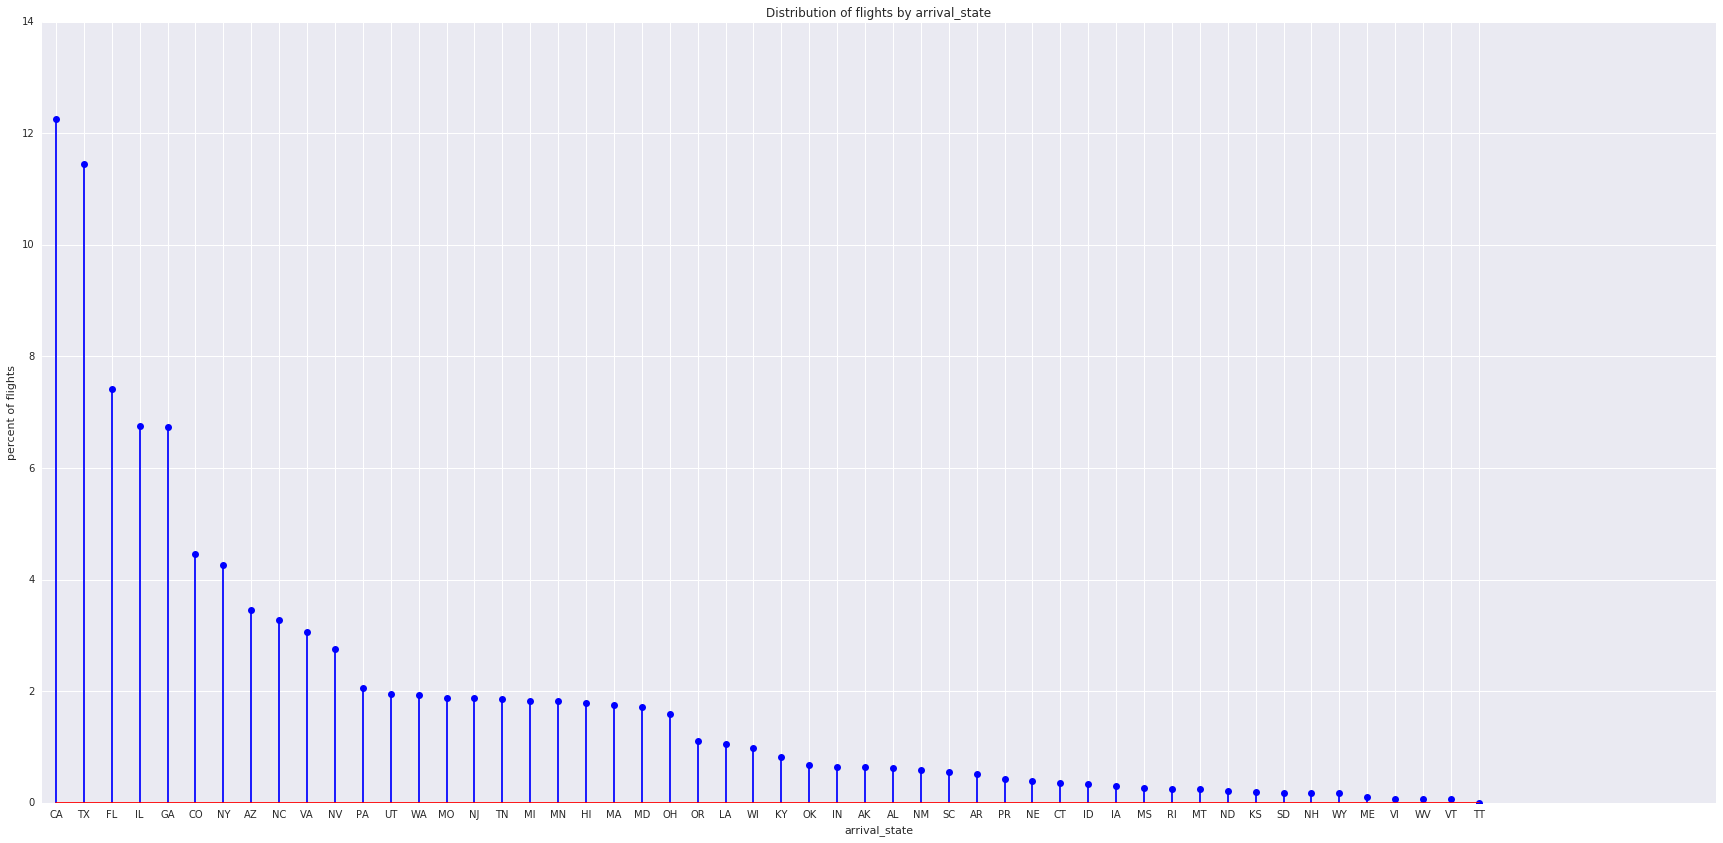

In [130]:
distr_arrival_state = get_flights_distribution_for_slices(["arrival_state"])
plot_distribution_for_slice(distr_arrival_state, "arrival_state")

### What are the most frequently travelled routes?

In [73]:
# Get distribution of flight routes.
distr_flight_routes = get_flights_distribution_for_slices(["departure_state", "arrival_state"])
# Put it in matrix form.
distr_flight_routes_p = distr_flight_routes.pivot(index="departure_state",
                                                  columns="arrival_state",
                                                  values="frequency").fillna(1)
# Normalize by total number of flights
total_number_flights = distr_flight_routes.frequency.sum()
distr_flight_routes_p /= total_number_flights
distr_flight_routes_p *= 100

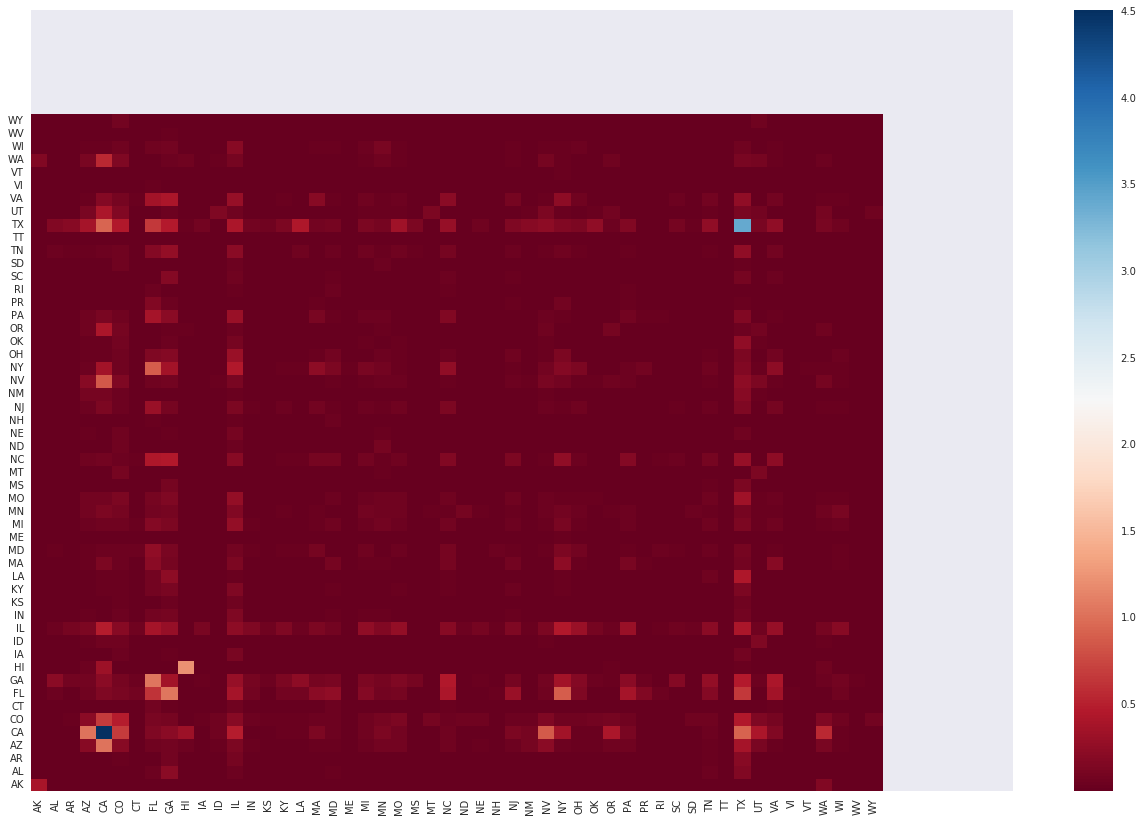

In [120]:
min_value = distr_flight_routes_p.values.min()
max_value = distr_flight_routes_p.values.max()
items = distr_flight_routes_p.columns.tolist()
ticks = np.arange(0.5, len(items) + 0.5)
plot.figure(figsize = (22, 14))
plot.pcolor(distr_flight_routes_p.values, cmap='RdBu', vmin=min_value, vmax=max_value)
plot.xticks(ticks, items, rotation = 'vertical')
plot.yticks(ticks, items)
plot.colorbar()
plot.show()

### On what days of the week do people travel the most?

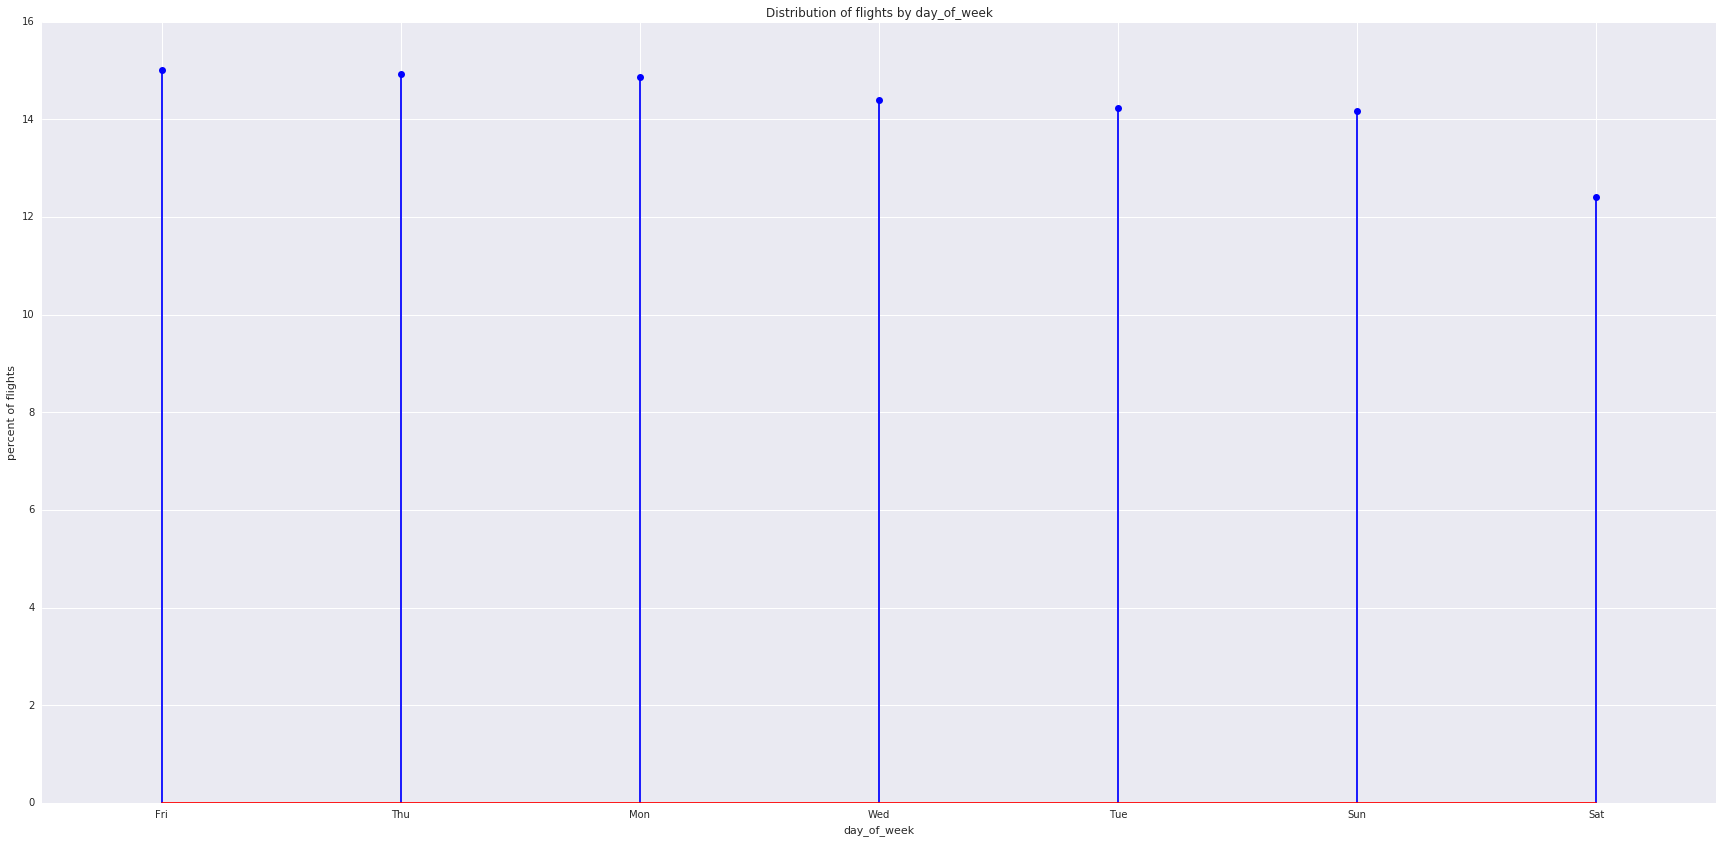

day_of_week  frequency
0         Fri    1426580
1         Thu    1417893
2         Mon    1412048
3         Wed    1367172
4         Tue    1353232
5         Sun    1345979
6         Sat    1179641

In [140]:
distr_day_of_week = get_flights_distribution_for_slices(["day_of_week"])
plot_distribution_for_slice(distr_day_of_week, "day_of_week")
distr_day_of_week

### On which day of the month?

In [143]:
distr_day_of_month = get_flights_distribution_for_slices(["day_of_month"])
distr_day_of_month['frequency'] /= distr_day_of_month['frequency'].sum()
distr_day_of_month

day_of_month  frequency
0             13   0.033736
1             20   0.033573
2              6   0.033549
3             16   0.033447
4             27   0.033397
5             21   0.033183
6             17   0.033160
7             14   0.033145
8              9   0.033122
9             23   0.033094
10            18   0.033062
11            26   0.032996
12             7   0.032979
13            19   0.032873
14            28   0.032854
15            12   0.032834
16            11   0.032816
17            15   0.032754
18            10   0.032672
19             2   0.032638
20             5   0.032624
21             8   0.032579
22            24   0.032357
23            22   0.032336
24             4   0.032210
25             3   0.032206
26            25   0.032175
27             1   0.032045
28            29   0.030921
29            30   0.030296
30            31   0.018366

### The 13th? Is it mostly a friday

In [144]:
distr_day_of_week_and_month = get_flights_distribution_for_slices(["day_of_week", "day_of_month"])
distr_day_of_week_and_month["frequency"] /= distr_day_of_week_and_month["frequency"].sum()
distr_day_of_week_and_month

day_of_week  day_of_month  frequency
0           Mon            26   0.006065
1           Fri            27   0.006060
2           Fri            18   0.006055
3           Fri            13   0.006049
4           Thu            17   0.006030
5           Fri            16   0.006029
6           Mon             2   0.006023
7           Mon             9   0.006020
8           Fri             6   0.006016
9           Thu            15   0.006008
10          Mon            16   0.006007
11          Thu            19   0.006006
12          Thu            12   0.006001
13          Mon            30   0.005996
14          Fri            14   0.005993
15          Thu            26   0.005983
16          Fri             2   0.005967
17          Fri            28   0.005965
18          Fri            11   0.005961
19          Fri            21   0.005958
20          Mon            14   0.005956
21          Mon            23   0.005952
22          Mon            28   0.005951
23          Thu            10   0.005948
24          Fri            30   0.005947
25          Fri             9   0.005943
26          Mon            12   0.005943
27          Thu             6   0.005942
28          Thu            29   0.005941
29          Thu             1   0.005940
..          ...           ...        ...
187         Fri             5   0.001590
188         Mon             8   0.001580
189         Wed            10   0.001578
190         Wed             3   0.001578
191         Tue             2   0.001567
192         Mon             1   0.001567
193         Tue             9   0.001561
194         Mon            15   0.001549
195         Fri            31   0.001533
196         Fri            26   0.001532
197         Thu            18   0.001530
198         Mon            22   0.001527
199         Wed            17   0.001522
200         Sun            31   0.001515
201         Fri            19   0.001515
202         Thu            25   0.001510
203         Tue            16   0.001505
204         Wed            24   0.001501
205         Sun             7   0.001495
206         Wed            31   0.001477
207         Tue            23   0.001474
208         Sun            14   0.001469
209         Tue            30   0.001432
210         Mon            29   0.001428
211         Sun            21   0.001424
212         Sat             6   0.001356
213         Sat            13   0.001350
214         Sat            20   0.001263
215         Sun            28   0.001144
216         Sat            27   0.001076

[217 rows x 3 columns]

## Analysis of arrival delay distribution

In [207]:
"""
Generate a sql statement to retrieve delay information per slice.
Args:
  slices: a list of table columns for over which to compute the information
  delay: either |departure_delay|, |arrival_delay|
  aggregate_function: a string of a valid SQL aggregate function (avg, max, min) or
    an integer representing the percentile of interest.
"""
def query_delay_by_slices(slices, delay, aggregate_function="avg"):
  # define convert aggregate_function to a valid SQL statement
  sql_aggregate_statement = ""
  aggregate_name = ""
  type_aggr = type(aggregate_function)
  type_int = type(0)
  type_str = type("")
  if (type_aggr == type_str):
    sql_aggregate_statement = "{0}({1})".format(aggregate_function, delay)
    aggregate_name = "{0}_{1}".format(aggregate_function, delay)
  elif (type_aggr == type_int):
    # assume that aggregate_function is a percentile
    sql_aggregate_statement = "NTH({0}, QUANTILES({1}, 101))".format(aggregate_function+1, delay)
    aggregate_name = "percentile_{0}".format(aggregate_function)
  
  return """SELECT
              {0},
              {1} as {2},
              COUNT(0) as num_flights
            FROM flighs_dataset.datatonic_extended,
            GROUP BY {0},
            ORDER BY {2} DESC;""".format(",".join(slices),
                                         sql_aggregate_statement,
                                         aggregate_name)

def get_delay_info_by_slices(slices, delay, aggregate_function):
  return bq.Query(query_delay_by_slices(slices, delay, aggregate_function)).to_dataframe()

"""
Plots the 2-D dataframe.

Args:
  distr_df: pandas.Dataframe as returned by get_delay_info_by_slices
  slice: list of length one with the name of the slice
"""
def plot_delay_info(delay_df, slice, delay_type):
  fig = plt.figure(figsize = (30,14))
  plot = fig.add_subplot(111)
  ticks = np.arange(0.5, len(delay_df[slice]) + 0.5)
  plot.stem(ticks, delay_df[delay_type], linefmt='b-', markerfmt='bo', lw=5)
  plt.xticks(ticks, delay_df[slice])
  plt.title("{0} of flights by {1}".format(delay_type, slice))
  plt.xlabel(slice)
  plt.ylabel(delay_type)
  plt.show()

### Which destination has the highest average delay?

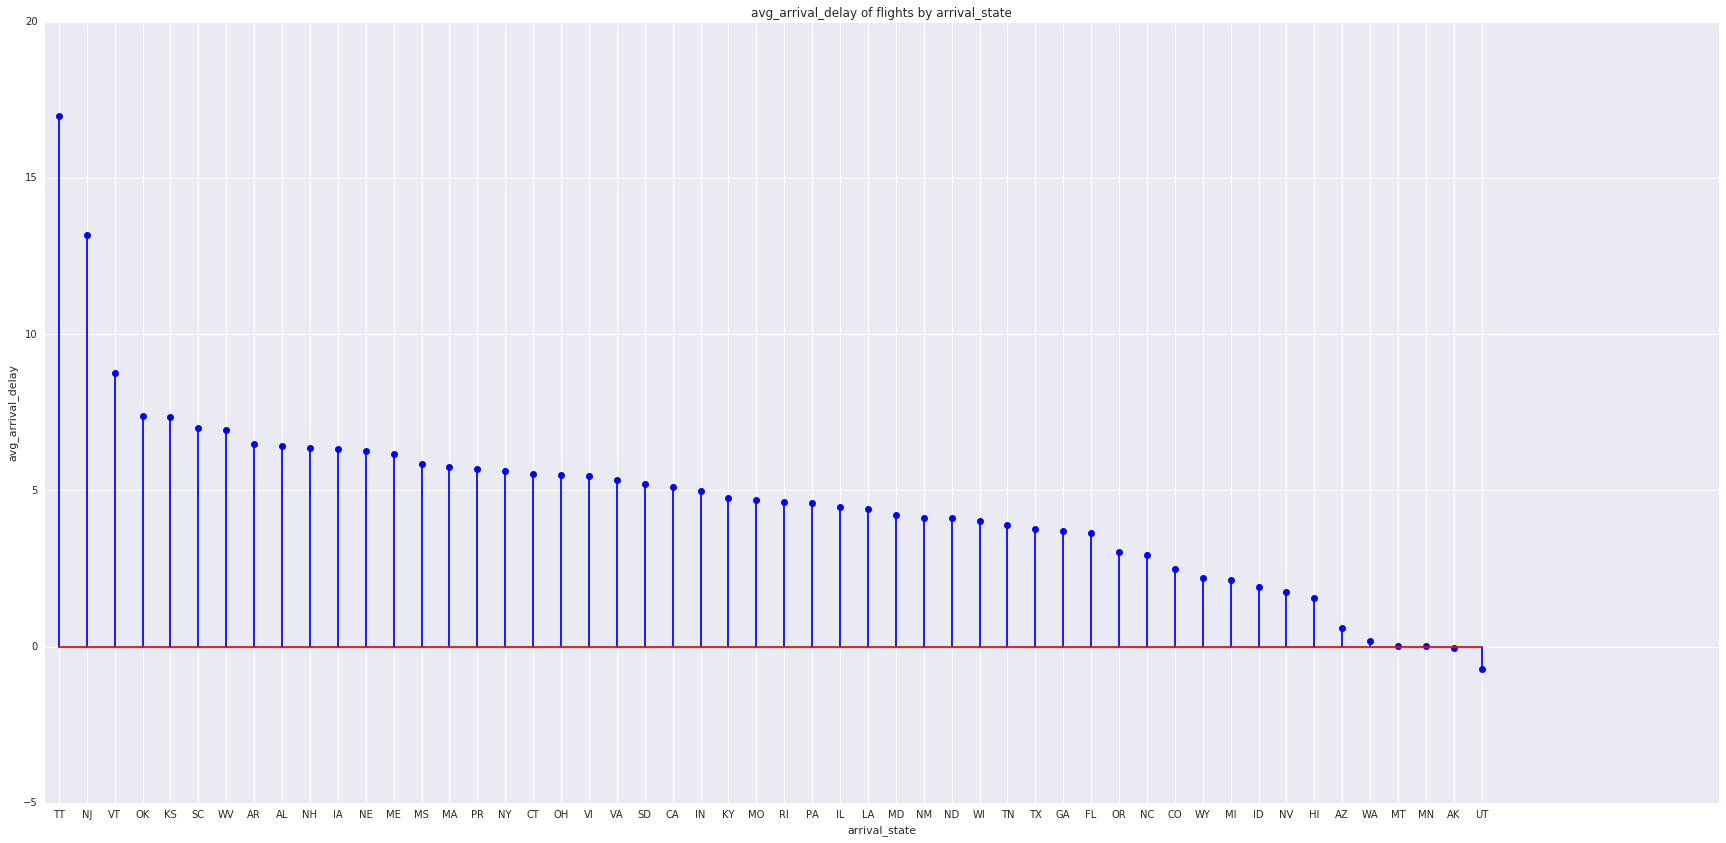

In [216]:
delay_info_df = get_delay_info_by_slices(["arrival_state"], "arrival_delay", "avg")
plot_delay_info(delay_info_df, "arrival_state", "avg_arrival_delay")

### Which origin has the highest average delay

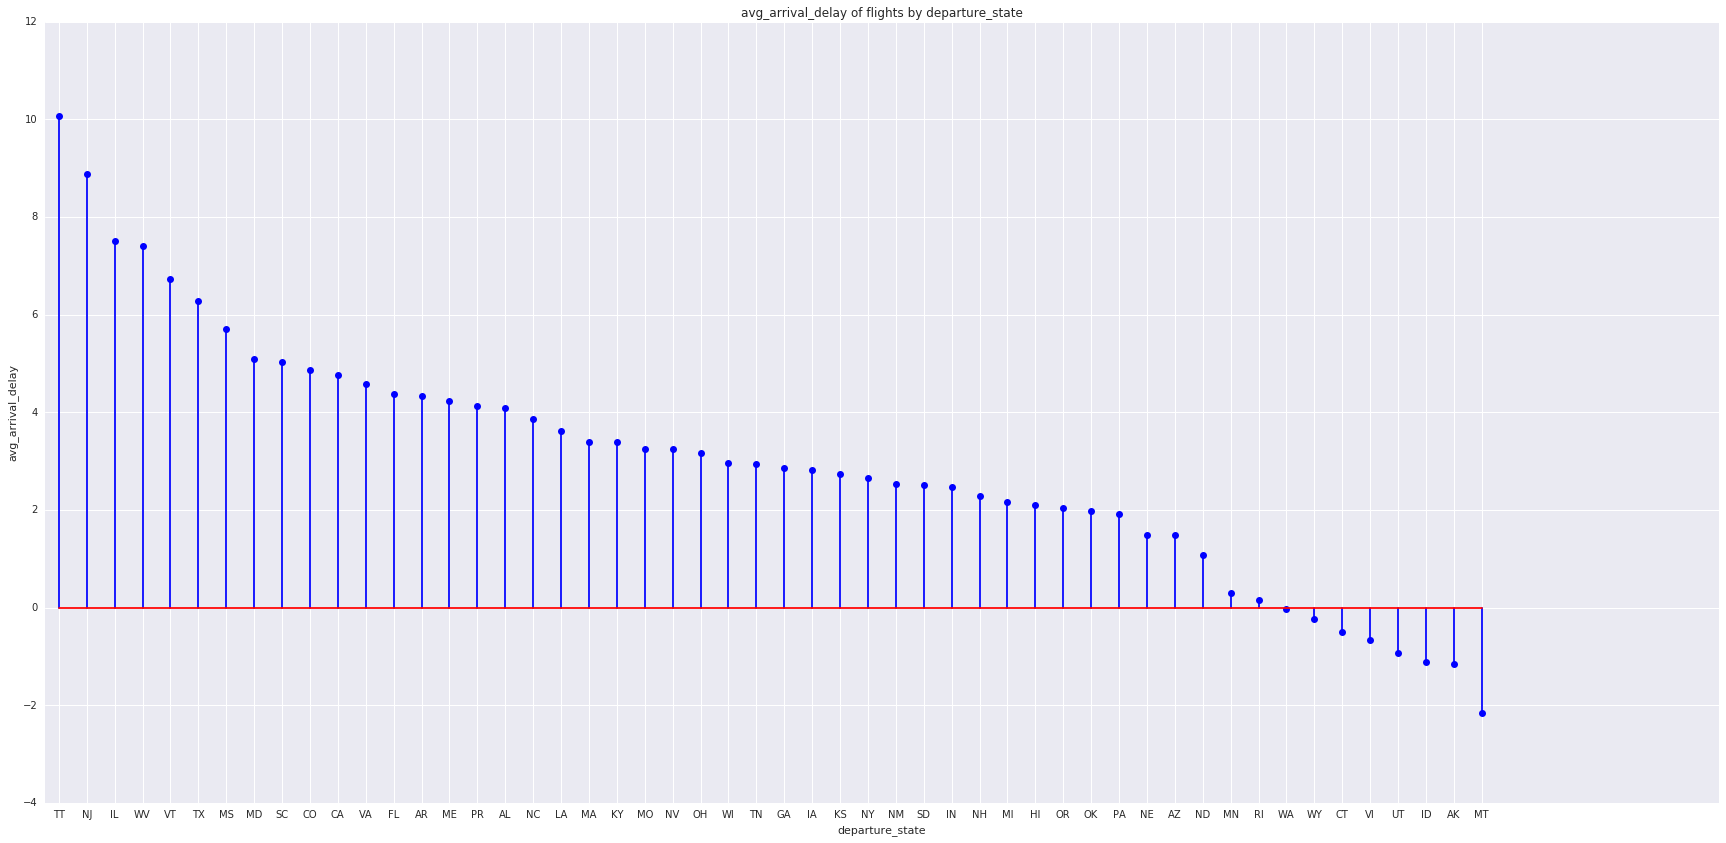

In [187]:
delay_info_df = get_delay_info_by_slices(["departure_state"], "arrival_delay", "avg")
plot_delay_info(delay_info_df, "departure_state", "avg_arrival_delay")

### What are the routes with the highest average delay

In [222]:
# Get delay by flight routes.
flight_routes_delay = get_delay_info_by_slices(["departure_state", "arrival_state"], "arrival_delay", "avg")
# Put it in matrix form.
flight_routes_delay_p = flight_routes_delay.pivot(index="departure_state",
                                                  columns="arrival_state",
                                                  values="avg_arrival_delay").fillna(0)

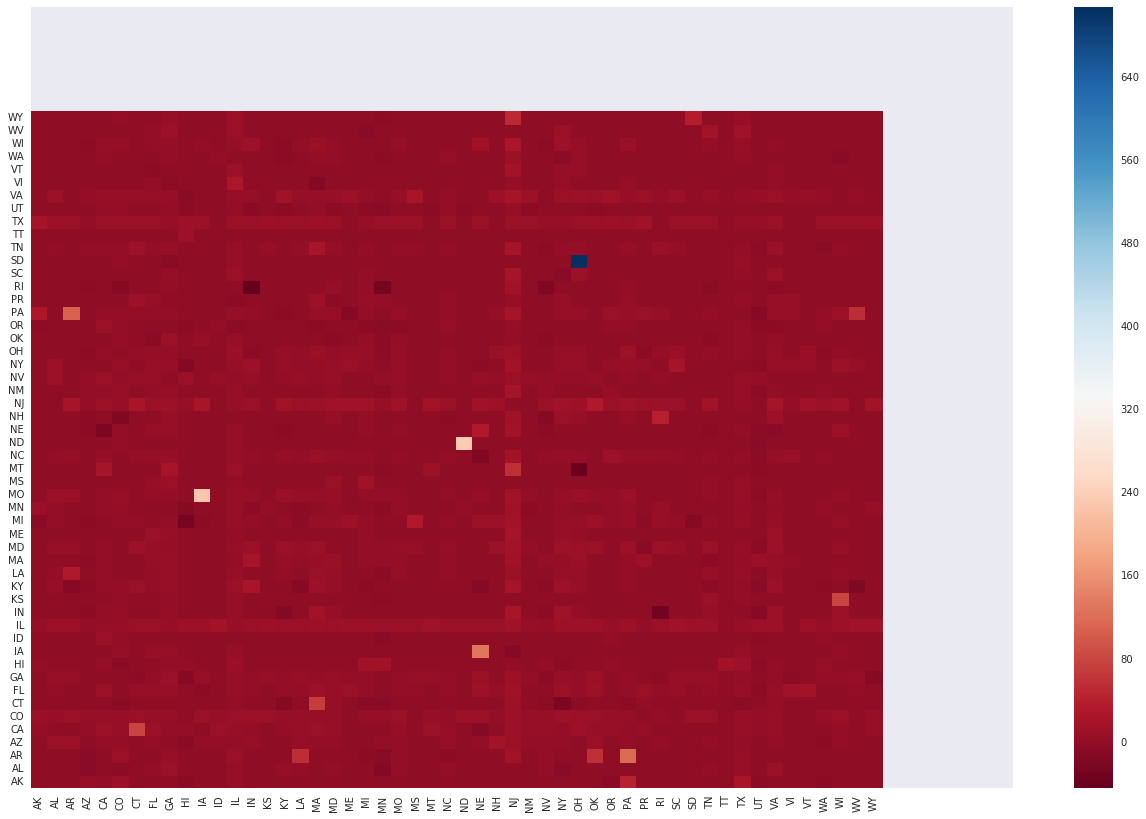

In [223]:
min_value = flight_routes_delay_p.values.min()
max_value = flight_routes_delay_p.values.max()
items = flight_routes_delay_p.columns.tolist()
ticks = np.arange(0.5, len(items) + 0.5)
plot.figure(figsize = (22, 14))
plot.pcolor(flight_routes_delay_p.values, cmap='RdBu', vmin=min_value, vmax=max_value)
plot.xticks(ticks, items, rotation = 'vertical')
plot.yticks(ticks, items)
plot.colorbar()
plot.show()

### Which day are planes most likely to be late

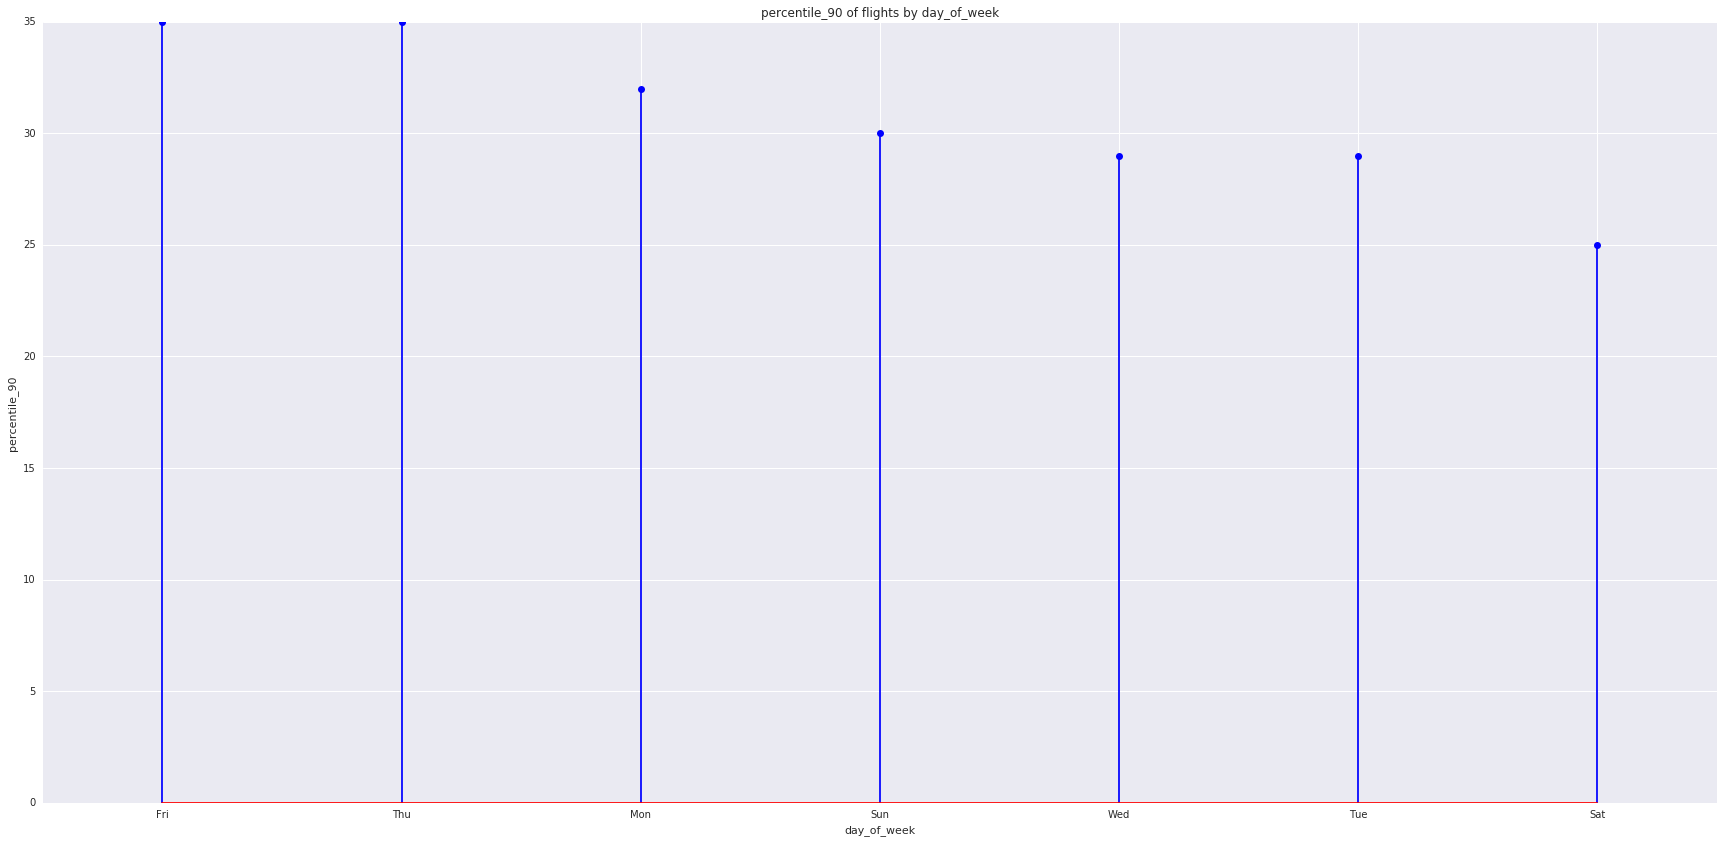

In [224]:
delay_info_df = get_delay_info_by_slices(["day_of_week"], "arrival_delay", 90)
plot_delay_info(delay_info_df, "day_of_week", "percentile_90")

In [230]:
delay_info_airline_df = get_delay_info_by_slices(["airline"], "arrival_delay", 90)
delay_info_airline_df['airline_name'] = delay_info_airline_df['airline'].apply(lambda x: airline_code_to_name[x])
delay_info_airline_df.loc[:,["airline_name", "percentile_90"]]

airline_name  percentile_90
0   Atlantic Southeast Airlines           49.0
1               JetBlue Airways           47.0
2                       Unknown           46.0
3               United Airlines           37.0
4             American Airlines           37.0
5          Continental Airlines           34.0
6       American Eagle Airlines           33.0
7              SkyWest Airlines           32.0
8             Frontier Airlines           32.0
9                Virgin America           32.0
10           Southwest Airlines           27.0
11                   US Airways           25.0
12                Mesa Airlines           24.0
13              Delta Air Lines           23.0
14              AirTran Airways           21.0
15         Alaska Airlines, Inc           16.0
16            Hawaiian Airlines           10.0

### Hour of day (departure) when planes are most likely to be late

In [239]:
%%sql --module delay_by_hour
SELECT
  COUNT(0) as num_flights,
  NTH(91, QUANTILES(arrival_delay, 101)) as percentile_90,
  FLOOR(departure_schedule / 100) + ROUND((departure_schedule % 100) /60.) as departure_hour
FROM flighs_dataset.datatonic_extended
GROUP BY departure_hour
ORDER BY departure_hour DESC;

In [240]:
bq.Query(delay_by_hour).to_dataframe()

num_flights  percentile_90  departure_hour
0         25471           31.0            24.0
1         89164           33.0            23.0
2        231587           40.0            22.0
3        335975           49.0            21.0
4        480898           49.0            20.0
5        550621           49.0            19.0
6        602422           47.0            18.0
7        621465           44.0            17.0
8        556915           41.0            16.0
9        608740           36.0            15.0
10       583126           34.0            14.0
11       585711           30.0            13.0
12       606807           26.0            12.0
13       609482           24.0            11.0
14       622293           21.0            10.0
15       622702           19.0             9.0
16       606906           17.0             8.0
17       623227           13.0             7.0
18       496474           11.0             6.0
19        20886            9.0             5.0
20          949           37.0             4.0
21         1476           25.0             3.0
22         3842           20.0             2.0
23        12565           19.0             1.0
24         2840           31.0             0.0
25            1          612.0             NaN

### Hour of day (arrival) when planes are most likely to be late

In [241]:
%%sql --module delay_by_hour
SELECT
  COUNT(0) as num_flights,
  NTH(91, QUANTILES(arrival_delay, 101)) as percentile_90,
  FLOOR(arrival_schedule / 100) + ROUND((arrival_schedule % 100) /60.) as arrival_hour
FROM flighs_dataset.datatonic_extended
GROUP BY arrival_hour
ORDER BY arrival_hour DESC;

In [242]:
bq.Query(delay_by_hour).to_dataframe()

num_flights  percentile_90  arrival_hour
0        170435           45.0          24.0
1        384993           47.0          23.0
2        481526           50.0          22.0
3        588560           47.0          21.0
4        558580           47.0          20.0
5        623672           43.0          19.0
6        619550           40.0          18.0
7        629531           36.0          17.0
8        616916           32.0          16.0
9        560257           28.0          15.0
10       614366           26.0          14.0
11       577635           23.0          13.0
12       575284           20.0          12.0
13       602544           19.0          11.0
14       578680           16.0          10.0
15       523941           13.0           9.0
16       404425           12.0           8.0
17       191128           12.0           7.0
18        73382           22.0           6.0
19        27319           25.0           5.0
20         1406           52.0           4.0
21         1255           45.0           3.0
22         4727           34.0           2.0
23        36135           47.0           1.0
24        56296           47.0           0.0
25            2          612.0           NaN